In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from itertools import product

from tqdm import tqdm_notebook

import random
import math
import os
import time as time 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import rcParams

import seaborn as sns

from sklearn import metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset

from utils import (
    load_and_partition_data,
    split_sequence
)

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("sales_train_validation.csv")
sell_prices = pd.read_csv("sell_prices.csv")
calendar = pd.read_csv("calendar.csv")
# validation contains 28 more dates
validation = pd.read_csv("sales_train_evaluation.csv")

d_cols = [c for c in train.columns if 'd_' in c]
dates = calendar[calendar.d.isin(d_cols)]['date']
dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

df_sales = train[d_cols].T
df_sales.columns = train['id'].values
df_sales = pd.DataFrame(df_sales).set_index([dates_list])
df_sales.index = pd.to_datetime(df_sales.index)

#Select arbitrary index and plot the time series
index = 6780
sales = pd.DataFrame(df_sales.iloc[:,index])
sales = pd.DataFrame(sales).set_index([dates_list])
TS_selected = sales
sales.index = pd.to_datetime(sales.index)

sales = sales.iloc[215:]
print(sales.shape)
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

(1698, 1)


In [3]:
d_cols = [c for c in validation.columns if 'd_' in c]
dates = calendar[calendar.d.isin(d_cols)]['date']
dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

df_validation = validation[d_cols].T
df_validation.columns = validation['id'].values

df_validation = pd.DataFrame(df_validation).set_index([dates_list])
df_validation.index = pd.to_datetime(df_validation.index)

#Select arbitrary index and plot the time series
sales_validation = pd.DataFrame(df_validation.iloc[:,index])
sales_validation = pd.DataFrame(sales_validation).set_index([dates_list])
sales_validation.index = pd.to_datetime(sales_validation.index)

sales_validation = sales_validation.iloc[215:]

sales_validation.columns = ['sales']
print(sales_validation.shape)

(1726, 1)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Adds positional encoding to the given tensor.

        Args:
            x: tensor to add PE to [bs, seq_len, embed_dim]

        Returns:
            torch.Tensor: tensor with PE [bs, seq_len, embed_dim]
        """
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


class TransformerWithPE(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, num_layers: int
    ) -> None:
        """Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()

        self.positional_encoding = PositionalEncoding(embed_dim)

        self.encoder_embedding = torch.nn.Linear(
            in_features=in_dim, out_features=embed_dim
        )
        self.decoder_embedding = torch.nn.Linear(
            in_features=out_dim, out_features=embed_dim
        )

        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)

        self.transformer = torch.nn.Transformer(
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            d_model=embed_dim,
            batch_first=True,
        )

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        # if self.train:
        # Add noise to decoder inputs during training
        # tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)

        # Embed encoder input and add positional encoding.
        # [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        # Generate mask to avoid attention to future outputs.
        # [tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
        # Embed decoder input and add positional encoding.
        # [bs, tgt_seq_len, embed_dim]
        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        # Get prediction from transformer and map to output dimension.
        # [bs, tgt_seq_len, embed_dim]
        pred = self.transformer(src, tgt, tgt_mask=tgt_mask.to(device))
        pred = self.output_layer(pred)

        return pred

    def infer(self, src: torch.Tensor, tgt_len: int) -> torch.Tensor:
        """Runs inference with the model, meaning: predicts future values
        for an unknown sequence.
        For this, iteratively generate the next output token while
        feeding the already generated ones as input sequence to the decoder.

        Args:
            src: input to the encoder [bs, src_seq_len, num_features]
            tgt_len: desired length of the output

        Returns:
            torch.Tensor: inferred sequence
        """
        output = torch.zeros((src.shape[0], tgt_len + 1, src.shape[2])).to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = self.forward(src, output)[:, i]

        return output[:, 1:]

In [6]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model, 'Models/transformer_w_residuals.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
from sklearn.preprocessing import MinMaxScaler

data = np.array(sales)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [8]:
model = torch.load('Models/transformer_best.pth').to(device)

In [9]:
sequences = load_and_partition_data(train_data_normalized, 29)
sequences_tensor = Variable(torch.Tensor(sequences))

model.eval()
with torch.no_grad():
    src, tgt, tgt_y = split_sequence(sequences_tensor, 28/29)
    predicts_ = model(src.to(device), tgt.to(device))
predicts_ = predicts_.cpu().numpy().reshape(-1)

forecasts_ = np.zeros(28)
src = train_data_normalized[-28:]
src = Variable(torch.Tensor(src)).unsqueeze(0)
tgt_len = 1
model.eval()
with torch.no_grad():
    forecasted = model.infer(src.to(device), tgt_len)
forecasts_[0] = forecasted.cpu().data.numpy()[0][0][0]
for i in range(1, 28):
    src = torch.cat((src[:, 1:].to(device), forecasted), dim = 1)
    model.eval()
    with torch.no_grad():
        forecasted = model.infer(src.to(device), tgt_len)
    forecasts_[i] = forecasted.cpu().data.numpy()[0][0][0]

all_prediction = np.append(predicts_, forecasts_)
results_df = pd.DataFrame()
results_df['sales'] = scaler.inverse_transform(all_prediction.reshape(-1, 1)).reshape(-1)
results_df.index = sales_validation.index[28:]

In [10]:
original_prediction_df = results_df.iloc[:-28]
original_forecast_df = results_df.iloc[-28:]

scaler1 = MinMaxScaler((-1, 1))
scaler2 = MinMaxScaler((-1, 1))

original_prediction_residuals_df = sales_validation[28:-28]-original_prediction_df
scaled_original_prediction_residuals_df = pd.DataFrame(scaler1.fit_transform(sales_validation[:-28])[28:] - scaler2.fit_transform(original_prediction_df))

original_forecast_residuals_df = sales_validation[-28:]-original_forecast_df

# Residual Analysis

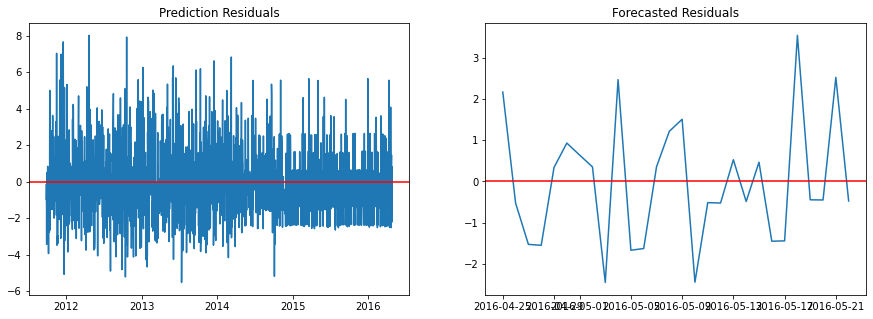

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(original_prediction_residuals_df)
ax[0].axhline(0, color='red')
ax[0].set_title('Prediction Residuals')
ax[1].plot(original_forecast_residuals_df)
ax[1].axhline(0, color='red')
ax[1].set_title('Forecasted Residuals')
plt.show()

NormaltestResult(statistic=array([113.1725766]), pvalue=array([2.66003432e-25]))
mu: -0.12356657085126031, sigma: 1.9977924534078642


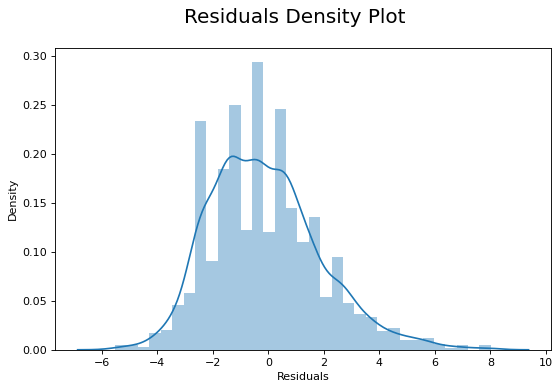

In [12]:
figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
print(stats.normaltest(original_prediction_residuals_df))

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(original_prediction_residuals_df)
print(f"mu: {mu}, sigma: {sigma}")

sns.distplot(original_prediction_residuals_df)
plt.suptitle('Residuals Density Plot', fontsize=18)
plt.xlabel('Residuals')

plt.show()

NormaltestResult(statistic=array([1.29286141]), pvalue=array([0.52391244]))
mu: -0.01965696151767458, sigma: 1.510116302985075


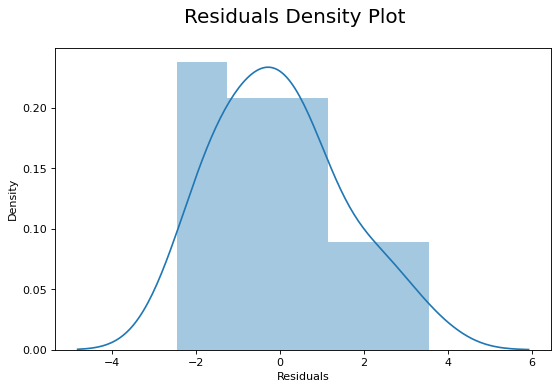

In [13]:
figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
print(stats.normaltest(original_forecast_residuals_df))

# Get the fitted parameters used by the function
(mu2, sigma2) = stats.norm.fit(original_forecast_residuals_df)
print(f"mu: {mu2}, sigma: {sigma2}")

sns.distplot(original_forecast_residuals_df)
plt.suptitle('Residuals Density Plot', fontsize=18)
plt.xlabel('Residuals')

plt.show()

# Training Transformer Model with sales and residuals output

In [14]:
mu = original_prediction_residuals_df.mean()[0]

total_residuals = [mu]*27+list(original_prediction_residuals_df['sales'])
total_residuals = np.array(total_residuals).reshape(len(total_residuals), 1)

total_residuals_df = pd.DataFrame(total_residuals)
total_residuals_df.index = sales.index[:-1]

y_scaler = MinMaxScaler((-1, 1))
r_scaler = MinMaxScaler((-1, 1))

y_scaler.fit(sales.values.reshape(-1, 1))
r_scaler.fit(total_residuals_df.values.reshape(-1, 1))
normalized_y = y_scaler.transform(sales.iloc[:-1])
normalized_r = r_scaler.transform(total_residuals_df)

normalized_data = np.concatenate([normalized_y, normalized_r], axis=1)

In [15]:
optimal_batch_size = 32
optimal_d_model = 64
optimal_num_head = 4
optimal_num_layer = 2

In [16]:
sequences = load_and_partition_data(normalized_data, 29)

train_data = torch.tensor(np.array(sequences[:-28]), dtype=torch.float)
val_data = torch.tensor(np.array(sequences[-28:]), dtype=torch.float)

train_loader = DataLoader(train_data, batch_size=optimal_batch_size , shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=optimal_batch_size, shuffle=False, drop_last=False)

#### Training

In [ ]:
#####  Parameters  ######################
num_features = len(normalized_data[0])
D_MODEL = optimal_d_model 
NUM_HEADS = optimal_num_head 
NUM_LAYERS = optimal_num_layer
NUM_EPOCHS = 200
LR = 0.001

#####Init the Model #######################
model = TransformerWithPE(num_features, num_features, D_MODEL, NUM_HEADS, NUM_LAYERS)
model.to(device)

##### Early Stopper ########################
early_stopper = EarlyStopper(patience=20)
##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=20,factor =0.1 ,min_lr=1e-7, eps=1e-08)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

start_time = time.time()
# Train the model
train_loss_, val_loss_ = [], []
for epoch in range(NUM_EPOCHS): 
    train_loss, val_loss = 0, 0
    model.train()
    for batch in train_loader:
        src, tgt, tgt_y = split_sequence(batch, 28/29)
        pred = model(src.to(device), tgt.to(device))
        loss = criterion(pred, tgt_y.to(device))
        train_loss += loss.item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss/=len(train_loader.dataset)
    train_loss_.append(train_loss)
    #Evaluate on test     
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            src, tgt, tgt_y = split_sequence(batch, 28/29)
            pred = model(src.to(device), tgt.to(device))
            loss = criterion(pred, tgt_y.to(device))
            val_loss += loss.item()
    val_loss/=len(val_loader.dataset)
    val_loss_.append(val_loss)
    scheduler.step(val_loss)
    if early_stopper.early_stop(val_loss):
        early_stopped = epoch+1
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch+1, train_loss,val_loss))
        break
    if epoch % 10 == 0:
      print("Epoch: %d, train loss: %1.5f valid loss:  %1.10f " %(epoch+1, train_loss,val_loss))
time_taken = time.time() - start_time
print(f"Time Taken :{time_taken}")

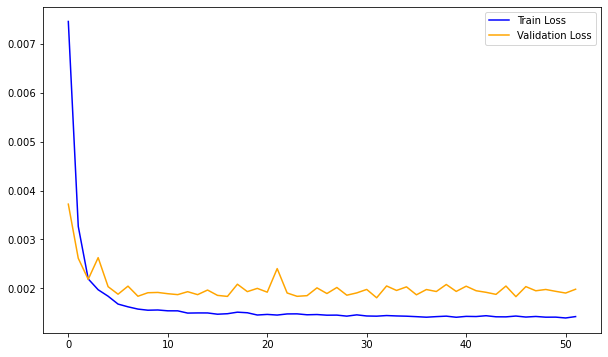

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_, label="Train Loss", color='blue')
plt.plot(val_loss_, label="Validation Loss", color='orange')
plt.legend()
plt.show()

#### Load Pre-trained Model

In [40]:
model = torch.load('Models/transformer_w_residuals.pth').to(device)

## Using predicted residuals as testing feature

In [41]:
start_time = time.time()
sequences_tensor = Variable(torch.Tensor(sequences))
model.eval()
with torch.no_grad():
    src, tgt, tgt_y = split_sequence(sequences_tensor, 28/29)
    predicts_ = model(src.to(device), tgt.to(device))
predicts_ = predicts_.cpu().numpy().reshape(-1, 2)

forecasts_ = np.zeros((28, 2))
src = normalized_data[-28:]
src = Variable(torch.Tensor(src)).unsqueeze(0)

tgt_len = 1
model.eval()
with torch.no_grad():
    forecasted = model.infer(src.to(device), tgt_len)
predicts_ = np.concatenate([predicts_, forecasted.cpu().data.numpy()[0]])

forecasted[0][0][0] = y_scaler.transform([[sales.iloc[-1, 0]]])[0][0]
for i in range(28):
    src = torch.cat((src[:, 1:].to(device), forecasted), dim = 1)
    model.eval()
    with torch.no_grad():
        forecasted = model.infer(src.to(device), tgt_len)
    forecasts_[i][0] = forecasted.cpu().data.numpy()[0][0][0]
    forecasts_[i][1] = forecasted.cpu().data.numpy()[0][0][1]
time_taken = time.time() - start_time
print(f"Time Taken :{time_taken}")

Time Taken :0.3289058208465576


In [42]:
all_prediction = np.append(predicts_[:, 0], forecasts_[:, 0])
prediction_df = pd.DataFrame()
prediction_df['sales'] = y_scaler.inverse_transform(all_prediction.reshape(-1, 1)).reshape(-1)
prediction_df.index = sales_validation.index[28:]

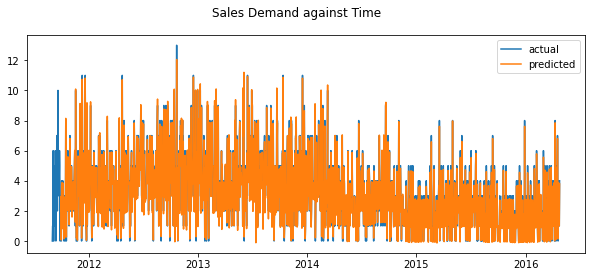

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(sales_validation[:-28], label='actual')
plt.plot(prediction_df[:-28], label='predicted')
plt.suptitle("Sales Demand against Time")
plt.legend()
plt.show()

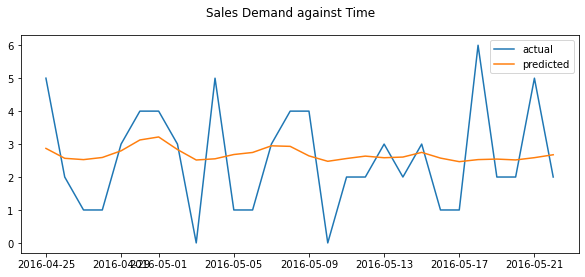

In [44]:
plt.figure(figsize=(10, 4))
plt.plot(sales_validation[-28:], label='actual')
plt.plot(prediction_df[-28:], label='predicted')
plt.suptitle("Sales Demand against Time")
plt.legend()
plt.show()

In [45]:
print("RMSE (train): ", np.sqrt(mean_squared_error(sales_validation[28:-28], prediction_df[:-28])))
print("R2 Score (train): ", r2_score(sales_validation[28:-28], prediction_df[:-28]))
print("RMSE (test): ", np.sqrt(mean_squared_error(sales_validation[-28:], prediction_df[-28:])))
print("R2 Score (test): ", r2_score(sales_validation[-28:], prediction_df[-28:]))

RMSE (train):  0.1836653994593828
R2 Score (train):  0.9934922920876553
RMSE (test):  1.504234195359137
R2 Score (test):  0.07988958332033391


In [46]:
sales_validation.columns = ["sales"]

original_prediction_df = prediction_df.iloc[:-28]
original_forecast_df = prediction_df.iloc[-28:]

original_prediction_residuals_df = sales_validation[28:-28]-original_prediction_df
original_forecast_residuals_df = sales_validation[-28:]-original_forecast_df

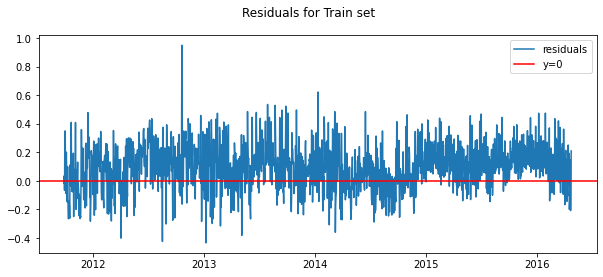

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(original_prediction_residuals_df, label="residuals")
plt.axhline(0, color='red', label="y=0")
plt.suptitle("Residuals for Train set")
plt.legend()
plt.show()

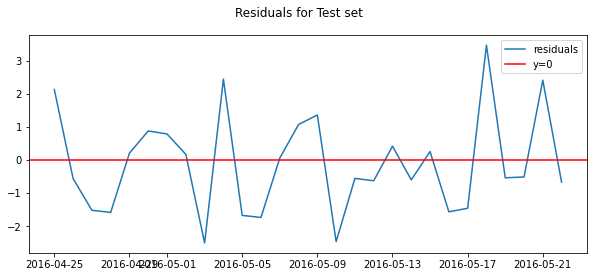

In [48]:
plt.figure(figsize=(10, 4))
plt.plot(original_forecast_residuals_df, label="residuals")
plt.axhline(0, color='red', label="y=0")
plt.suptitle("Residuals for Test set")
plt.legend()
plt.show()

## Using sample mean as testing feature

In [49]:
start_time = time.time()
sequences_tensor = Variable(torch.Tensor(sequences))

model.eval()
with torch.no_grad():
    src, tgt, tgt_y = split_sequence(sequences_tensor, 28/29)
    predicts_ = model(src.to(device), tgt.to(device))
predicts_ = predicts_.cpu().numpy().reshape(-1, 2)
time_taken = time.time() - start_time
print(f"Time Taken :{time_taken}")

Time Taken :0.0640571117401123


In [50]:
start_time = time.time()
forecasts_ = np.zeros((28, 2))
src = normalized_data[-28:]
src = Variable(torch.Tensor(src)).unsqueeze(0)
tgt_len = 1
model.eval()
with torch.no_grad():
    forecasted = model.infer(src.to(device), tgt_len)
predicts_ = np.concatenate([predicts_, forecasted.cpu().data.numpy()[0]])

forecasted[0][0][0] = y_scaler.transform([[sales.iloc[-1, 0]]])[0][0]
for i in range(28):
    forecasted[0][0][1] = torch.tensor(r_scaler.transform([[mu]])[0][0]).to(device)
    src = torch.cat((src[:, 1:].to(device), forecasted), dim = 1)
    model.eval()
    with torch.no_grad():
        forecasted = model.infer(src.to(device), tgt_len)
    forecasts_[i][0] = forecasted.cpu().data.numpy()[0][0][0]
    forecasts_[i][1] = forecasted.cpu().data.numpy()[0][0][1]
time_taken = time.time() - start_time
print(f"Time Taken :{time_taken}")

Time Taken :0.27457094192504883


In [51]:
all_prediction = np.append(predicts_[:, 0], forecasts_[:, 0])
prediction_df = pd.DataFrame()
prediction_df['sales'] = y_scaler.inverse_transform(all_prediction.reshape(-1, 1)).reshape(-1)
prediction_df.index = sales_validation.index[28:]

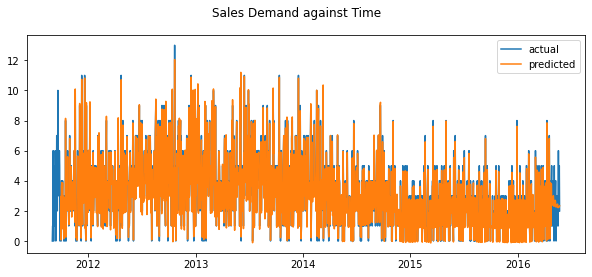

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(sales_validation, label='actual')
plt.plot(prediction_df, label='predicted')
plt.suptitle("Sales Demand against Time")
plt.legend()
plt.show()

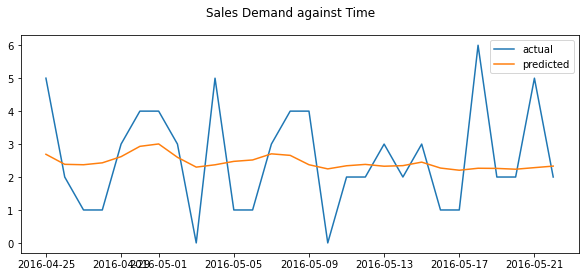

In [53]:
plt.figure(figsize=(10, 4))
plt.plot(sales_validation[-28:], label='actual')
plt.plot(prediction_df[-28:], label='predicted')
plt.suptitle("Sales Demand against Time")
plt.legend()
plt.show()

In [54]:
print("RMSE (train): ", np.sqrt(mean_squared_error(sales_validation[28:-28], prediction_df[:-28])))
print("R2 Score (train): ", r2_score(sales_validation[28:-28], prediction_df[:-28]))
print("RMSE (test): ", np.sqrt(mean_squared_error(sales_validation[-28:], prediction_df[-28:])))
print("R2 Score (test): ", r2_score(sales_validation[-28:], prediction_df[-28:]))

RMSE (train):  0.1836653994593828
R2 Score (train):  0.9934922920876553
RMSE (test):  1.5104595760728765
R2 Score (test):  0.07225793845176387


In [55]:
sales_validation.columns = ["sales"]

original_prediction_df = prediction_df.iloc[:-28]
original_forecast_df = prediction_df.iloc[-28:]

original_prediction_residuals_df = sales_validation[28:-28]-original_prediction_df
original_forecast_residuals_df = sales_validation[-28:]-original_forecast_df

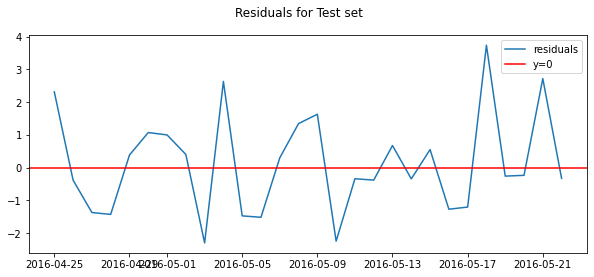

In [56]:
plt.figure(figsize=(10, 4))
plt.plot(original_forecast_residuals_df, label="residuals")
plt.axhline(0, color='red', label="y=0")
plt.suptitle("Residuals for Test set")
plt.legend()
plt.show()